# MNIST

`fetch_mldata()` is deprecated since Scikit-Learn 0.20. You should use `fetch_openml()` instead. However, it returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [1]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:

import numpy as np
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [12]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [13]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [14]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

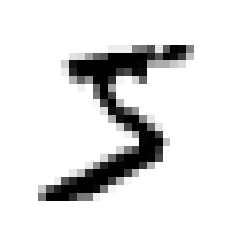

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")


In [16]:
y = y.astype(np.uint8)

The MNIST is actually already split into a training set and test set

In [64]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us.

In [65]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

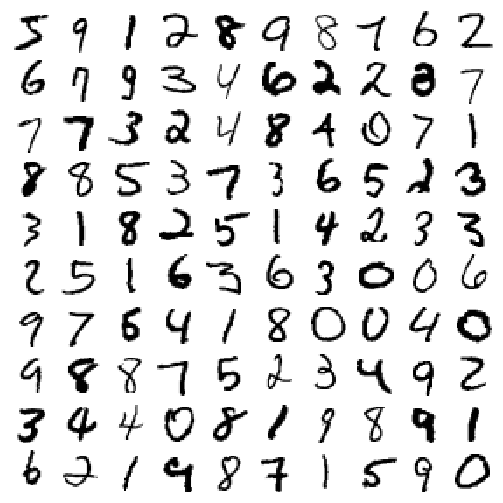

In [66]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

## Training a Binary Classifier

We will try to identify one digit, the number 5. This is an example of binary classifier.

In [67]:
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5) 

Now let's pick a classifier and train. We will use a Stochastic Gradiant Descent (SGD)

In [84]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

We can use it to detect i,ages od the number 5:


In [85]:
sgd_clf.predict([some_digit])

array([ True])

## Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation.

### Implementing Cross-Validation

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [72]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling.

Let's use the cross_val_score() function to evaluate our SGDClassifier

In [73]:
from  sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [74]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [75]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Only 10% of the i,ages are 5s, so if yoy always guess thath an image is not 5, you will be right about 90% of the time. 

For this reason, acurracy is generally not the preferred performance measure for classifier, especially when you dealing tih skewd datasets.

## Confusion Matrix

In [76]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Like cross_vale_secore() function, cross_val_prediction() performs K-fold cross-validaition, but instead of returning the evaluation score, it retruns the predictions made on each rest fold.

In [88]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

actual vs predict class

## Precision and Recall

In [91]:
from sklearn.metrics import precision_score, recall_score

In [92]:
precision_score(y_train_5, y_train_pred) # == 4096/(4096 + 1522)

0.8370879772350012

In [93]:
recall_score(y_train_5, y_train_pred) ## == 4344 / (4344 + 1077)

0.6511713705958311

The $F_{1}$ score is the "harmnonic mean" of precision an recall. This gives much mor weight to low values.

$F_{1} = 2 x \frac{precision * recall}{precision + recall}$

In [94]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade-Off

Precision-recall tradeoff occur due to increasing one of the parameter(precision or recall) while keeping the model same. This is possible, for instance, by changing the threshold of the classifier.

In [95]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [96]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [97]:
y_some_digit_pred

array([ True])

We will use _cross_val_predict()_  function to get the scores of all instance in the training set.

In [114]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the _precision_recall_curve()_ funtion to compute precision and recall for all possible thresholds:

In [115]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

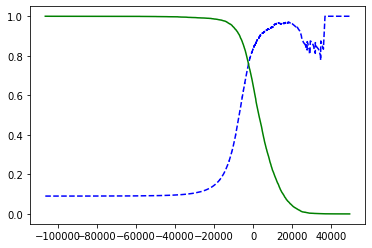

In [116]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [118]:
(y_train_pred == (y_scores > 0)).all()

True

In [121]:
threshold_90_precision = thresholds[np.argmax(precisions>= 0.90)]

In [122]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [123]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

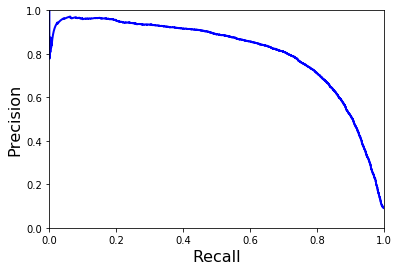

In [124]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

## ROC Curve

The _receiver operating characteristic_ (ROC) is it very similar to the precision/recall curve,. The ROC curve plots the _tru positive rate_ against _false positive rate_

In [125]:
from sklearn.metrics import roc_curve

In [126]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

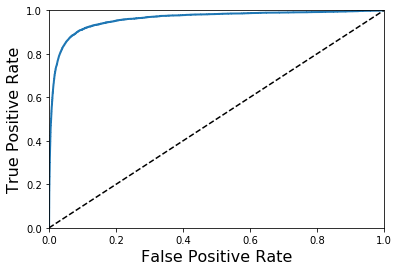

In [127]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

In [128]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Now, let's train a Random Forest and we will compare both models.

The Random Forest doesn't a _decision_function()_ method. Instead, it has a _predict_proba()_ method.

In [134]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier( random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [139]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

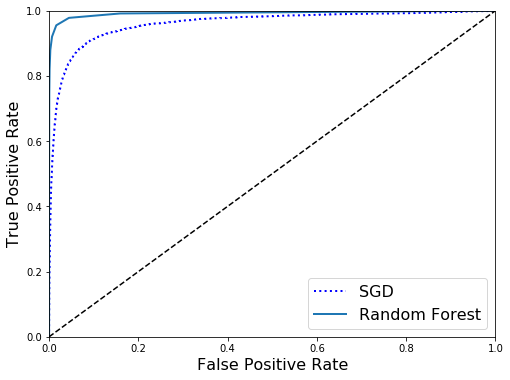

In [140]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [141]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## Multiclass Classification

In [152]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([score_digit])
some_digit_scores